In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

traindf=pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv')
valdf=pd.read_csv('/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv')
traindf.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [2]:
traindf=traindf.drop(['Id','Tags','CreationDate'], axis=1)
traindf['Y']=traindf['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2})
valdf=valdf.drop(['Id','Tags','CreationDate'], axis=1)
valdf['Y']=valdf['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2})

traindf.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


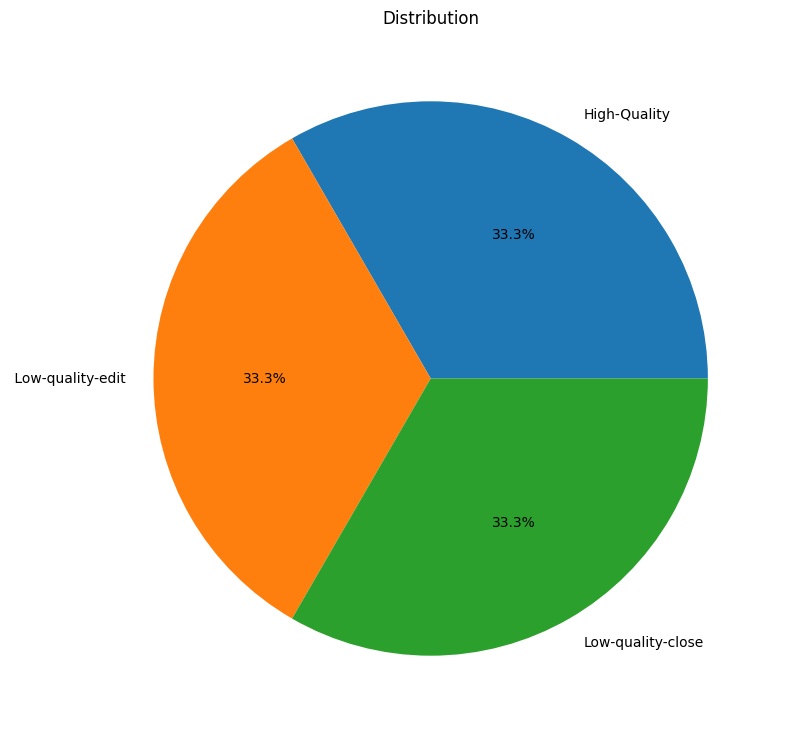

In [3]:
lbl=['High-Quality',' Low-quality-edit','Low-quality-close']
val=[len(traindf[traindf['Y']==2]),len(traindf[traindf['Y']==1]),len(traindf[traindf['Y']==0])]
plt.figure(figsize=(16,9))
plt.pie(x=val,labels=lbl,autopct="%1.1f%%")
plt.title("Distribution")
plt.show()

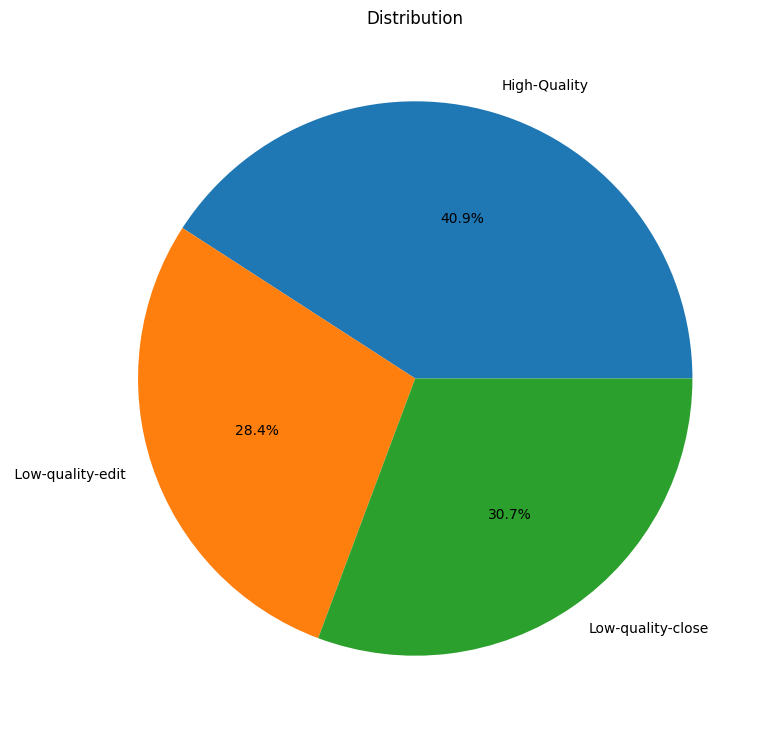

In [4]:
lbl=['High-Quality',' Low-quality-edit','Low-quality-close']
val=[len(valdf[traindf['Y']==2]),len(valdf[traindf['Y']==1]),len(valdf[traindf['Y']==0])]
plt.figure(figsize=(16,9))
plt.pie(x=val,labels=lbl,autopct="%1.1f%%")
plt.title("Distribution")
plt.show()

In [5]:
traindf['txt']=traindf['Title']+''+traindf['Body']
traindf=traindf.drop(['Title','Body'],axis=1)

valdf['txt']=valdf['Title']+''+valdf['Body']
valdf=valdf.drop(['Title','Body'],axis=1)

traindf.head()

,Y,txt
0,0,Java: Repeat Task Every Random Seconds<p>I'm a...
1,2,Why are Java Optionals immutable?<p>I'd like t...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky?<p>T...
4,2,hide/show fab with scale animation<p>I'm using...


In [6]:
import re
def clean_txt(text):
    text.lower()
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
traindf['txt']=traindf['txt'].apply(clean_txt)
valdf['txt']=valdf['txt'].apply(clean_txt)
traindf.head()

,Y,txt
0,0,Java Repeat Task Every Random SecondspIm alrea...
1,2,Why are Java Optionals immutablepId like to un...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so pickypThe ...
4,2,hideshow fab with scale animationpIm using cus...


In [7]:
traindf=traindf.sample(frac=1).reset_index(drop=True)
valdf=valdf.sample(frac=1).reset_index(drop=True)

trainx=traindf['txt']
trainy=traindf['Y']

valx=valdf['txt']
valy=valdf['Y']

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector=TfidfVectorizer()
trainx=vector.fit_transform(trainx)
valx=vector.transform(valx)

In [31]:
from xgboost import XGBClassifier
# Define and fit the classifier on the data
xg_classifier = XGBClassifier()
xg_classifier.fit(trainx, trainy)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
print(f"Validation Accuracy of XGBoost Clf. is: {(xg_classifier.score(valx, valy))*100:.2f}%")


Validation Accuracy of XGBoost Clf. is: 84.27%


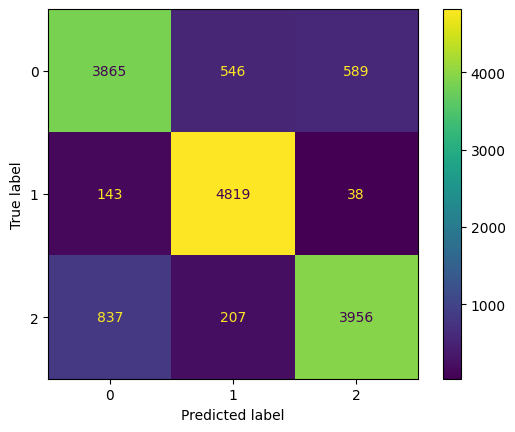

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xg_classifier, valx, valy)

In [28]:
from lightgbm import LGBMClassifier

# Define the classifier with desired parameters (optional)
lgb_classifier = LGBMClassifier(objective='multiclass', # Adjust objective for multi-class
                               n_estimators=180, # Number of trees
                               learning_rate=0.4)  # Learning rate

# Fit the classifier on the data
lgb_classifier.fit(trainx, trainy)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.187314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372601
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 7470
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(learning_rate=0.4, n_estimators=180, objective='multiclass')

In [30]:
print(f"Validation Accuracy of XGBoost Clf. is: {(lgb_classifier.score(valx, valy))*100:.2f}%")


Validation Accuracy of XGBoost Clf. is: 86.32%


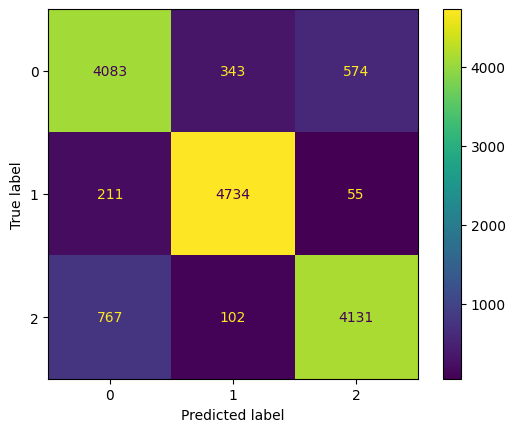

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lgb_classifier, valx, valy)